# Modélisation de la propagation de l'épidémie du Covid : Simulation multi-agents

Auteur : Maxime Gatineau, Élève Ingénieur de l'[École Centrale de Lille](https://ecole.centralelille.fr/) <br/>
Tuteur : Philippe Mathieu, [CRIStAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/gt/i2c/) <br/>
Création : Septembre 2020

### Objectifs

Nous souhaitons modéliser à l’échelle microscopique l’évolution de l’épidémie du covid en France. <br/>
Notre but est de pouvoir faire des prévisions à court termes sur la propagation de l'épidémie et de sortir les paramètres qui impactent la force et la vitesse de la propagation.

### Principes

Un système multi-agents est un système dans lequel des entités dotées de leur propre comportement, intéragissent entre-elles. <br/>
Nos agents doivent représenter la population française, ils auront différentes caractéristiques, par exemple l'âge et le sexe. <br/>
Les agents seront reliés entre eux selon un modèle de Barabási-Albert, qui génére aléatoirement un réseau invariant d'échelle et qui permet de représenter un réseau social pour des interactions humaines. <br/>
Ensuite, sur un principe de tour de parole, nous allons interroger chaque agents, regarder leurs connexions et dire s'ils peuvent être contaminés par les agents qui les entourent. <br/>
Enfin, l'utilisation d'un algorithme génétique permettra d'accorder les paramètres avec les données que nous avons en France.

### Table des matières <a class="anchor" id="tdm"></a>

* [Chapitre 1 : Simulation](#c1)
    * [Partie 1 : Caractéristiques de la population française](#c1-p1)
    * [Partie 2 : Simulation multi-agents](#c1-p2)
    * [Partie 3 : Facteurs de contagion](#c1-p3)
    * [Partie 4 : Simulation avec une contagion aléatoire](#c1-p4)
* [Chapitre 2 : Graphes](#c2)
    * [Partie 1 : Graphe de l'évolution du Covid en France](#c2-p1)
* [Sources](#s)

### Librairies :

In [2]:
import numpy as np
import csv 
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time 
import glob
from datetime import date

## Chapitre 1 : Simulation <a class="anchor" id="c1"></a>

### Partie 1 : Caractéristiques de la population française <a class="anchor" id="c1-p1"></a>

Explications : 

[Table des matières](#tdm)

Pour notre étude, les paramètres se basent sur les sources et s'implémentent de la manière suivante : 
* Pour l'âge : 
     * 0 = < 15 ans
     * 1 = entre 15 et 30 ans
     * 2 = entre 30 et 55 ans
     * 3 = > 55 ans
     
     
* Pour le sexe :
    * 0 = homme
    * 1 = femme


* Pour le poids :
    * 0 = Dénutrition (IMC < 18.5)
    * 1 = Normal (18.5 > IMC > 25)
    * 2 = Surpoids (25 > IMC > 30)
    * 3 = Obésité (IMC > 30)


* Pour le groupe sanguin : 
    * 0 = A+
    * 1 = O+
    * 2 = B+ 
    * 3 = AB+
    * 4 = A-
    * 5 = O-
    * 6 = B-
    * 7 = AB-

In [79]:
# Implémentation des paramètres sur une population

nb_agents = 7000
agentList = []
age=[]
sexe=[]
poids = []
groupe_sanguin = []

# Proportions cumulatives pour l'âge:
prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

# Par tranches d'âges les proportions normalisées sont :
prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

# Proportions cumulatives pour le poids :
prop_poids = [0.035,0.492,0.323,0.15]

# Proportions pour le groupe sanguin : 
prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

graph = nx.barabasi_albert_graph(nb_agents,1)
# Avec numpy array :
matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

# Initialize accointances based on the matrix
for i in range(nb_agents):
    agentList.append(Agent(i,np.nonzero(matrix[i])[0]))
    
for i in range(nb_agents):
    if 0 <= i <= int(nb_agents*prop_age[0]):
        age.append(0)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
    if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
        age.append(1)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
    if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
        age.append(2)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
    if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
        age.append(3)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
    poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
    groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

In [81]:
# Analyse de nos valeurs :

print("Implémentation des paramètres\n")
print(f"Il y a {nb_agents} agents.")
# On regarde que les tableaux aient la même taille :
print(f"Les tableaux sont de la même taille que le nombre d'agents : {len(age) == len(poids) == len(sexe) == nb_agents}\n")
# On compare avec les valeurs réelles : 
y = np.bincount(age)/nb_agents
ii = np.nonzero(y)[0]
# On prends la proportion d'âge non-cumulative :
prop_age_nc = np.array(prop_age)
for i in range(0,len(prop_age)):
    if i == 0:
        prop_age_nc[i] = prop_age[i]
    else:
        prop_age_nc[i] = prop_age[i] - prop_age[i-1]
print(f"La proportion par tranches d'âge (simulation - réelle) est :\n{np.vstack((ii,y[ii],prop_age_nc[ii])).T}\n")

y = np.bincount(sexe)/nb_agents
ii = np.nonzero(y)[0]
print(f"La proportion H/F (simulation - réelle) est :\n{np.vstack((ii,y[ii])).T}\n")

y = np.bincount(poids)/nb_agents
ii = np.nonzero(y)[0]
prop_poids = np.array(prop_poids)
print(f"La proportion du poids (simulation - réelle) est de :\n{np.vstack((ii,y[ii],prop_poids[ii])).T}\n")

y = np.bincount(groupe_sanguin)/nb_agents
ii = np.nonzero(y)[0]
prop_groupe_sanguin = np.array(prop_groupe_sanguin)
print(f"La proportion pour les groupes sanguins (simulation - réelle) est de :\n{np.vstack((ii,y[ii],prop_groupe_sanguin[ii])).T}")

Implémentation des paramètres

Il y a 7000 agents.
Les tableaux sont de la même taille que le nombre d'agents : True

La proportion par tranches d'âge (simulation - réelle) est :
[[0.         0.17814286 0.178     ]
 [1.         0.17314286 0.17324292]
 [2.         0.31757143 0.31758515]
 [3.         0.33114286 0.33117193]]

La proportion H/F (simulation - réelle) est :
[[0.    0.502]
 [1.    0.498]]

La proportion du poids (simulation - réelle) est de :
[[0.         0.037      0.035     ]
 [1.         0.494      0.492     ]
 [2.         0.31828571 0.323     ]
 [3.         0.15071429 0.15      ]]

La proportion pour les groupes sanguins (simulation - réelle) est de :
[[0.         0.37814286 0.38      ]
 [1.         0.35871429 0.36      ]
 [2.         0.07985714 0.08      ]
 [3.         0.02828571 0.03      ]
 [4.         0.07742857 0.07      ]
 [5.         0.05814286 0.06      ]
 [6.         0.01071429 0.01      ]
 [7.         0.00871429 0.01      ]]


En comparant les données obtenues avec celles des sources, on observe que les proportions obtenues sont correctes.

### Partie 2 : Simulation multi-agents <a class="anchor" id="c1-p2"></a>

Explications :

[Table des matières](#tdm)

In [82]:
# Création de la classe multi-agents

class SMA:
    def __init__(self, nb_agents, adjacency_matrix):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.10])[0])

        # Initialisation des paramètres se basant sur les sources :

        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [83]:
# Création de la classe Agent

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        if self.has_it:
            chosen = random.randint(0,len(sma.agentList)-1)

            self.has_it = False
            sma.agentList[random.randint(0,len(sma.agentList)-1)].has_it = parole

            print(f"L'agent {self.id_number} ({sma.sexe[self.id_number]}) pèse {sma.poids[self.id_number]} et est de groupe sanguin {sma.groupe_sanguin[self.id_number]} ! Il parle à l'agent {chosen}.")

In [84]:
# Exécution de la simulation
nb_agents = 7_000
nb_rounds = 5
temps_debut = time.time()

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1)
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix)

# On donne la parole
parole = "J'ai la parole."
an_agent = np.random.choice(sma.agentList)
an_agent.has_it = parole
print(f"Il y a {nb_agents} agents et {nb_rounds} tours.")

# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution est de {round(temps_fin-temps_debut,4)}s.")

# On reprend la balle, pour une éventuelle réexécution.
for agent in sma.agentList:
    if agent.has_it:
        agent.has_it = False

Il y a 7000 agents et 5 tours.
L'agent 3468 (0) pèse 3 et est de groupe sanguin 0 ! Il parle à l'agent 852.
L'agent 1183 (0) pèse 3 et est de groupe sanguin 1 ! Il parle à l'agent 3899.
L'agent 1127 (1) pèse 2 et est de groupe sanguin 1 ! Il parle à l'agent 2479.
L'agent 3200 (0) pèse 3 et est de groupe sanguin 1 ! Il parle à l'agent 2807.
L'agent 2707 (0) pèse 2 et est de groupe sanguin 7 ! Il parle à l'agent 1595.
L'agent 6955 (0) pèse 2 et est de groupe sanguin 0 ! Il parle à l'agent 4994.
L'agent 5458 (0) pèse 1 et est de groupe sanguin 0 ! Il parle à l'agent 5825.

Le temps d'exécution est de 2.3862s.


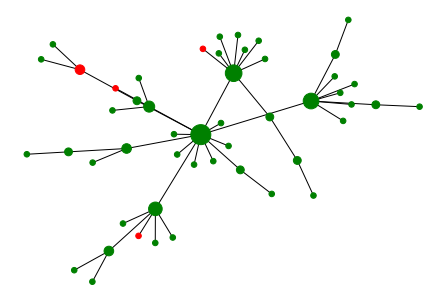

In [31]:
# Tracé des graphes sociaux sur une population plus petite
nb_agents = 50 # 50 est optimal pour le graphe, sinon les tailles sont trop disproportionné

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1)

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix)

color_map = []
for node in graph:
    if sma.malade[node] == 1:
        color_map.append('red')
    else: 
        color_map.append('green')  

size =  []
for node in graph:
    size.append(graph.degree(node))

max_value = np.max(size)
iterator = 0
for value in size:
    size[iterator] = (value/max_value)*400
    iterator += 1

my_pos = nx.spring_layout(graph, seed = 100)
    
plt.figure()
nx.draw(graph, pos=my_pos, node_color=color_map, node_size=size)
plt.axis('off')
plt.show()

### Partie 3 : Facteurs de contagion <a class="anchor" id="c1-p3"></a>

Explications :

[Table des matières](#tdm)

In [48]:
# Utilisation du graphe dans la classe Agent avec import dans la classe SMA :
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.10])[0])

        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        prop_poids = [0.035,0.492,0.323,0.15] 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 

In [70]:
# Explications sur la manière de récupèrer les alpha-contacts dans la classe Agent
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        alpha = 0.8
        if self.has_it:
            # Pour chaque agents j 
            for j in range(0,len(sma.agentList)):
                liens = []
                contact = []
                for i in range(0,len(list(graph.edges(j)))):
                    # print(list(graph.edges(j))[i][1])
                    # On récupère les agents en lien avec notre agent
                    # On les met dans un tableau
                    liens.append(list(graph.edges(j))[i][1])
                print(f"L'agent {j} a {len(liens)} liens")
                print(f"Les liens de l'agent {j} sont : {list(sma.graphe.edges(j))}")
                # On récupère aléatoirement alpha % de ces personnes
                for k in range(int(alpha*len(liens))):
                    print(f"On garde {alpha} % de liens donc : {int(alpha*len(liens))} contact")
                    valeur_contact = random.randint(0,int(alpha*len(liens)))
                    print(f"On récupère la personne {valeur_contact} dans la liste")
                    contact.append(liens.pop(valeur_contact))
                    print(f"Liens après {k} itérations : {liens}")
                    print(f"Contact à {k} itérations : {contact}")
                # On fait en sorte que chaque j agents aient au moins 1 contact :
                if (contact == []):
                    print(f"Comme garder {alpha} % de liens équivaut à {int(alpha*len(liens))} contact, l'agent {j} garde son unique lien.")
                    contact.append(liens[len(liens)-1])
                print(f"Au final, les alpha-contacts de {j} sont : {contact}\n")

In [71]:
# On relance notre expérience 
nb_agents = 10
nb_rounds = 2

# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) 

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph)

# On donne la parole
parole = "J'ai la parole."
an_agent = np.random.choice(sma.agentList)
an_agent.has_it = parole
print(f"Il y a {nb_agents} agents et {nb_rounds} tours.\n")

# On lance le jeu
sma.run(nb_rounds)

Il y a 10 agents et 2 tours.

L'agent 0 a 4 liens
Les liens de l'agent 0 sont : [(0, 1), (0, 2), (0, 3), (0, 6)]
On garde 0.8 % de liens donc : 3 contact
On récupère la personne 0 dans la liste
Liens après 0 itérations : [2, 3, 6]
Contact à 0 itérations : [1]
On garde 0.8 % de liens donc : 2 contact
On récupère la personne 0 dans la liste
Liens après 1 itérations : [3, 6]
Contact à 1 itérations : [1, 2]
On garde 0.8 % de liens donc : 1 contact
On récupère la personne 1 dans la liste
Liens après 2 itérations : [3]
Contact à 2 itérations : [1, 2, 6]
Au final, les alpha-contacts de 0 sont : [1, 2, 6]

L'agent 1 a 3 liens
Les liens de l'agent 1 sont : [(1, 0), (1, 4), (1, 7)]
On garde 0.8 % de liens donc : 2 contact
On récupère la personne 2 dans la liste
Liens après 0 itérations : [0, 4]
Contact à 0 itérations : [7]
On garde 0.8 % de liens donc : 1 contact
On récupère la personne 0 dans la liste
Liens après 1 itérations : [4]
Contact à 1 itérations : [7, 0]
Au final, les alpha-contacts de

### Partie 4 : Simulation avec une contagion aléatoire <a class="anchor" id="c1-p4"></a>

Explications : 

[Table des matières](#tdm)

In [143]:
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe, depart, alpha, beta, gamma, delta, incubation):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe
        self.immunise = [] # 1 = Oui, 0 = Non
        self.jour_malade = []
        
        self.alpha = alpha # contact
        self.beta = beta # contamination
        self.gamma = gamma # décès
        self.delta = delta # guérison
        self.incubation = incubation # période pendant laquelle le patient est malade

        self.plot_malade = []
        self.plot_vivant = []
        self.plot_immunise = []

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[1-depart,depart])[0])
            if self.malade[i] == 1:
                self.immunise.append(1)
            else:
                self.immunise.append(0)
            self.jour_malade.append(0)

        # Initialisation des paramètres se basant sur les sources :
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

        self.plot_malade.append(self.malade.count(1))
        self.plot_immunise.append(self.immunise.count(1))
        self.plot_vivant.append(self.vivant.count(1))

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            self.plot_malade.append(self.malade.count(1))
            self.plot_immunise.append(self.immunise.count(1))
            self.plot_vivant.append(self.vivant.count(1))
            
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [144]:
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        j = self.id_number

        # On regarde si l'agent malade va guérir ou mourir
        if sma.malade[j] == 1 and sma.vivant[j] == 1:
            if sma.jour_malade[j] <= sma.incubation:
                # Tous les jours, l'agent peut décéder :
                sma.vivant[j] = np.random.choice([0,1], 1, p=[sma.gamma,1-sma.gamma])[0]
                    # S'il meurt, il n'est plus malade
                if sma.vivant[j] == 0:
                    sma.malade[j] = 0
                    sma.jour_malade[j] += sma.incubation
                # ou guérir :
                sma.malade[j] = np.random.choice([0,1], 1, p=[sma.delta,1-sma.delta])[0]
                if sma.malade[j] == 0:
                    sma.jour_malade[j] += sma.incubation
                # Puis, pour chaque malade on compte 1 jour de plus pour ce tour
                sma.jour_malade[j] += 1
        
        # Après la période d'incubation, l'agent n'est plus malade
        if sma.jour_malade[j] > sma.incubation:
            sma.malade[j] = 0

        # Si l'agent j est vivant, on regarde s'il peut être contaminé :
        # Donc il faut qu'il soit sain et non immunisé
        if sma.vivant[j] == 1 and sma.immunise[j] == 0 and sma.malade[j] == 0:
            # On regarde tous ces liens et on garde uniquement les contacts
            liens = []
            contact = []
            for i in range(0,len(list(graph.edges(j)))):
                # On récupère les agents en lien avec notre agent
                # On les met dans un tableau
                liens.append(list(graph.edges(j))[i][1])
                # On récupère aléatoirement alpha % de ces personnes
            for k in range(int(sma.alpha*len(liens))):
                valeur_contact = random.randint(0,int(sma.alpha*len(liens)))
                contact.append(liens.pop(valeur_contact))
            # On fait en sorte que chaque j agents aient au moins 1 contact :
            if (contact == []):
                contact.append(liens[len(liens)-1])
            
            # Pour chaque personnes restantes dans les contacts, on regarde si elles sont malades
            for i in range(0,len(contact)):
                if sma.malade[contact[i]] == 1:
                    # Si un contact est malade, il y a beta % chances de contamination pour notre agent j
                    sma.malade[j] = np.random.choice([0,1], 1, p=[1-sma.beta,sma.beta])[0]
                    if sma.malade[j] == 1:
                        # Notre agent devient immunisé à son tour
                        sma.immunise[j] = 1
                        #print(f"L'agent {j} s'est fait contaminé par l'agent {contact[i]}")

Propagation du virus pour 700 agents et 60 jours.

Le temps d'exécution de la simulation est de 1.3639s.


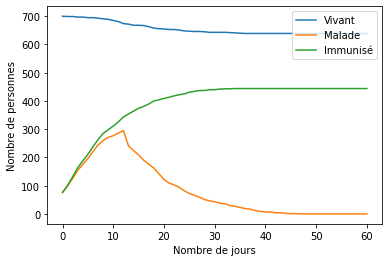

In [150]:
nb_agents = 700
nb_rounds = 60
print(f"Propagation du virus pour {nb_agents} agents et {nb_rounds} jours.")

# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) 
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

# Pour tester dans une boucle for : 
departs = [0.01, 0.05, 0.1, 0.2, 0.5]
alphas = [0.2, 0.4, 0.6, 0.8]
betas = [0.2, 0.4, 0.6, 0.8]
gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
deltas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
incubations = [2,4,6,8,10,12,14,15]

# Malheureusement, impossible d'avoir de belles courbes même après avoir tester tous les paramètres ci-dessus

depart = 0.1 # proportion de personnes contaminées au départ
alpha = 0.6 # contact
beta = 0.2 # contamination
gamma = 0.01 # décès
delta = 0.005 # guérison
incubation = 12 # période pendant laquelle l'agent est malade


matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph, depart, alpha, beta, gamma, delta, incubation)

temps_debut = time.time()
# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution de la simulation est de {round(temps_fin-temps_debut,4)}s.")

# Tracé de graphes :
x = []
for i in range(0,len(sma.plot_vivant)):
    x.append(i)

y = [sma.plot_vivant, sma.plot_malade, sma.plot_immunise]
labels = ['Vivant', 'Malade', 'Immunisé']

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
plt.xlabel('Nombre de jours')
plt.ylabel('Nombre de personnes')
plt.legend(loc="upper right")
plt.show()

## Chapitre 2 : Graphes <a class="anchor" id="c2"></a>

### Partie 1 : Graphe de l'évolution du Covid en France <a class="anchor" id="c2-p1"></a>

[Table des matières](#tdm)

In [85]:
# Création d'un csv avec les dates de 2020
with open('dates.csv', 'w', newline='') as file:
    writer = csv.writer(file,delimiter=',')
    writer.writerow(["date"])
    mois = [1,2,3,4,5,6,7,8,9,10,11,12]
    for m in mois:
        if m < 8:
            if m == 2:
                for j in range(1,30):
                    writer.writerow([f"{date(2020,m,j)}"])
            else:
                if m % 2 == 0:
                    for j in range(1,31):
                        writer.writerow([f"{date(2020,m,j)}"])
                if m % 2 != 0:
                    for j in range(1,32):
                        writer.writerow([f"{date(2020,m,j)}"])
        else:
            if m % 2 == 0:
                for j in range(1,32):
                    writer.writerow([f"{date(2020,m,j)}"])
            if m % 2 != 0:
                for j in range(1,31):
                    writer.writerow([f"{date(2020,m,j)}"])

In [86]:
# Collecte des données sur le site du gouvernement pour l'année 2020
def collecte_donnees(granularite='national'):
    print("Collecte des données du gouvernement")
    data_brute = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv',low_memory=False)
    dates = pd.read_csv('dates.csv')

    # National
    if granularite == "national":
        data_brute = data_brute.loc[data_brute['source_type'] == "ministere-sante"]
        data_brute = data_brute.loc[data_brute['granularite'] == "pays"].reset_index()
        data_brute = data_brute[['date','cas_confirmes', 'deces', 'deces_ehpad', 'reanimation', 'hospitalises', 'gueris']]
        data_brute = dates.set_index('date').join(data_brute.set_index('date'))
        data = data_brute.interpolate(limit_area='inside')
        data = data.dropna(how='all')
        data['reanimation'][0:3] = 0
        data['gueris'][0:3] = 0

    # Regional
    if granularite == "regional":
        data_brute = data_brute.loc[data_brute['source_type'] == "opencovid19-fr"]
        data_brute = data_brute.loc[data_brute['maille_code'] == "REG-32"].reset_index()
        data_brute = data_brute[['date','cas_confirmes', 'deces','deces_ehpad', 'reanimation', 'hospitalises', 'gueris']]
        data_brute = dates.set_index('date').join(data_brute.set_index('date'))
        data = data_brute.interpolate(limit_area='inside')
        data = data.dropna(how='all')
        data = data.loc['2020-03-18':]

    # Departemental
    if granularite == "departemental":
        data_brute = pd.read_csv(glob.glob('donnees-hospitalieres-covid19-*')[-1], sep=";")
        data_brute = data_brute.loc[data_brute['dep'] == "59"]
        data_brute[data_brute['sexe']==0].groupby(['jour']).sum()
        data = data.drop(columns=['sexe'])

    return data

Collecte des données du gouvernement
Création du graphe


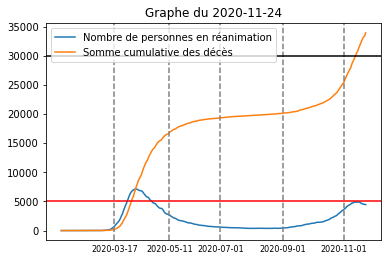

In [89]:
# Création du graphe de l'évolution du Covid en France

# date du jour :
today = date.today()

# Pour avoir toutes les données :
data = collecte_donnees()

# Pour plotter à l'échelle régionale ou départementale :
#data = collecte_donnees('regional')
#data = collecte_donnees('departemental')

print("Création du graphe")
# Plot de la figure : 
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data['reanimation'])
ax1.plot(data['deces'])

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

# Dates importantes :
# début-fin du premier confinement, début-fin été 2020, début du deuxième confinement : 
xcoords = ['2020-03-17','2020-05-11','2020-07-01','2020-09-01','2020-11-01']

for xc in xcoords:
    plt.axvline(x=xc,ls='--',c='gray')
    ax1.text(xc, -0.02, f"{xc}", color='black', transform=ax1.get_xaxis_transform(),
            ha='center', va='top', fontsize=8)

# Nombre de lits en réanimation :
plt.axhline(y=5000,c='red')

plt.axhline(y=30000,c='black')
plt.title(f"Graphe du {today}")
plt.legend(["Nombre de personnes en réanimation","Somme cumulative des décès"])
plt.savefig(f'./graph_covid.png')
plt.show()

### Sources <a class="anchor" id="s"></a>

[Table des matières](#tdm)

Utilisation de la mémoire dans une classe en Python :
https://habr.com/en/post/458518/ 

Réduction de la mémoire dans un dataset :
https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

Réduction de la mémoire dans un array numpy : https://pythonspeed.com/articles/numpy-memory-footprint/

Population française selon l'age et le sexe en 2020 : https://www.insee.fr/fr/statistiques/2381474

Obésite en France en 2012 : https://www.roche.fr/fr/innovation-recherche-medicale/decouverte-scientifique-medicale/cardio-metabolisme/enquete-nationale-obepi-2012.html

Groupes sanguins en France : https://www.ints.fr/SangTransfGrSanguin.aspx